# ColabでJuliaを使うためのノートブック v0.1

このノートブックの内容については再配布・改変・部分的コピーその他すべてを自由に行って構いません。

このノートブックは[Google Colabで実行できる](https://colab.research.google.com/github/genkuroki/public/blob/main/0054/Julia%20notebook%20for%20Google%20Colab.ipynb).

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

import Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]

"""必要ならPkg.addした後にusingしてくれる関数"""
function _using(pkg::AbstractString)
    if pkg in _packages_added
        println("# $(pkg).jl is already added.")
    else
        println("# $(pkg).jl is not added yet, so let's add it.")
        Pkg.add(pkg)
    end    
    println("> using $(pkg)")
    @eval using $(Symbol(pkg))
end

"""必要ならPkg.addした後にusingしてくれるマクロ"""
macro _using(pkg) :(_using($(string(pkg)))) end

# パッケージの追加と使用
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using LinearAlgebra
using Printf
using Random
Random.seed!(4649373)
##@_using BenchmarkTools
@_using Distributions
##@_using Optim
##@_using QuadGK
##@_using RDatasets
##@_using Roots
##@_using StatsBase
##@_using StatsFuns
##@_using SpecialFunctions
@_using StatsPlots
default(fmt=:png, legendfontsize=12)
##@_using SymPy

# Distributions.jl is already added.
> using Distributions
# StatsPlots.jl is already added.
> using StatsPlots


## ランダムウォーク

期待値が $\mu$ で標準偏差が $\sigma$ の確率分布の独立同分布確率変数列 $X_1,X_2,X_3,\ldots$について,

$$
W_n = (X_1-\mu)+(X_2-\mu)+\cdots+(X_n-\mu), \quad n=1,2,3,\ldots
$$

の様子がどうなるかを見てみよう.

(mu, sigma) = (mean(dist), std(dist)) = (6.0, 4.242640687119285)


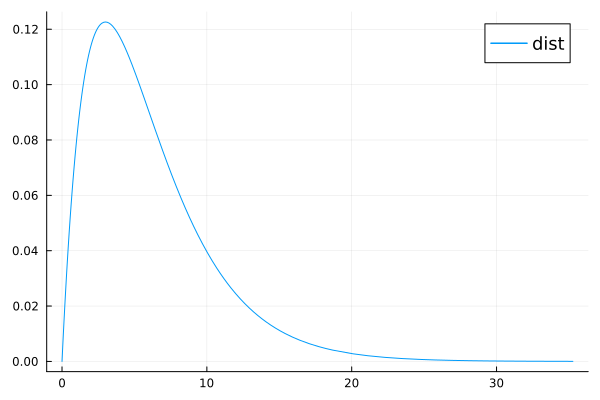

In [2]:
dist = Gamma(2, 3)
@show mu, sigma = mean(dist), std(dist)
plot(dist; label="dist")

In [3]:
X_minus_mu = rand(dist - mu, 10) # X_1 - mu, X_2 - mu, ..., X_10 - mu を生成

10-element Vector{Float64}:
  3.0311267478769928
 -1.4409032773374868
 -4.693642987661233
 -1.7502325815689757
 10.650497896417825
 -2.563141099889714
 -3.189505348153571
 -1.8701849265462256
 -3.0119934886403863
 -4.283202704007239

In [4]:
cumsum(X_minus_mu) # W_1, W_2, ..., W_10 を作成

10-element Vector{Float64}:
  3.0311267478769928
  1.590223470539506
 -3.1034195171217274
 -4.853652098690703
  5.796845797727122
  3.2337046978374078
  0.044199349683836875
 -1.8259855768623883
 -4.837979065502775
 -9.121181769510013

In [5]:
?cumsum

search: cumsum cumsum! sum



```
cumsum(A; dims::Integer)
```

Cumulative sum along the dimension `dims`. See also [`cumsum!`](@ref) to use a preallocated output array, both for performance and to control the precision of the output (e.g. to avoid overflow).

# Examples

```jldoctest
julia> a = [1 2 3; 4 5 6]
2×3 Matrix{Int64}:
 1  2  3
 4  5  6

julia> cumsum(a, dims=1)
2×3 Matrix{Int64}:
 1  2  3
 5  7  9

julia> cumsum(a, dims=2)
2×3 Matrix{Int64}:
 1  3   6
 4  9  15
```

!!! note
    The return array's `eltype` is `Int` for signed integers of less than system word size  and `UInt` for unsigned integers of less than system word size. To preserve `eltype` of arrays with small signed or unsigned integer `accumulate(+, A)` should be used.

    ```jldoctest
    julia> cumsum(Int8[100, 28])
    2-element Vector{Int64}:
     100
     128

    julia> accumulate(+,Int8[100, 28])
    2-element Vector{Int8}:
      100
     -128
    ```

    In the former case, the integers are widened to system word size and therefore the result is `Int64[100, 128]`. In the latter case, no such widening happens and integer overflow results in `Int8[100, -128]`.


---

```
cumsum(itr)
```

Cumulative sum of an iterator.

See also [`accumulate`](@ref) to apply functions other than `+`.

!!! compat "Julia 1.5"
    `cumsum` on a non-array iterator requires at least Julia 1.5.


# Examples

```jldoctest
julia> cumsum(1:3)
3-element Vector{Int64}:
 1
 3
 6

julia> cumsum((true, false, true, false, true))
(1, 1, 2, 2, 3)

julia> cumsum(fill(1, 2) for i in 1:3)
3-element Vector{Vector{Int64}}:
 [1, 1]
 [2, 2]
 [3, 3]
```


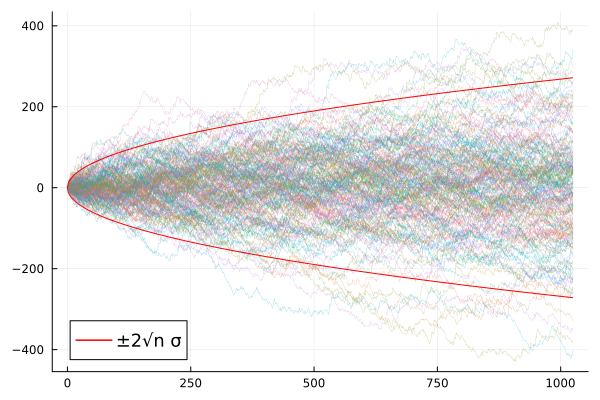

In [6]:
nmax = 2^10 # maximum sample size
niters = 200 # number of iterations
Ws = [cumsum(rand(dist - mu, nmax)) for _ in 1:niters] # [W_1, W_2, ..., W_nmax] をniters個生成

plot()
for W in Ws
    plot!([0; W]; label="", lw=0.3, alpha=0.5)
end
plot!(n ->  2sqrt(n)*sigma, 0, nmax; label="±2√n σ", c=:red)
plot!(n -> -2sqrt(n)*sigma, 0, nmax; label="", c=:red)

期待値が $0$ のギャンブルを $n$ 回繰り返すと, __トータルでの勝ち負けの金額__はおおよそ $\pm 2\sqrt{n}\;\sigma$ の範囲におさまる(ランダムウォークの偏差).

## 大数の法則

期待値が $0$ で標準偏差が $\sigma$ の確率分布の独立同分布確率変数列$X_1,X_2,X_3,\ldots$について, サイズ $n$ の標本平均

$$
\bar{X}_n = \frac{X_1+X_2+\cdots+X_n}{n}
$$

の様子がどうなるかを見てみよう.

(mu, sigma) = (mean(dist), std(dist)) = (6.0, 4.242640687119285)


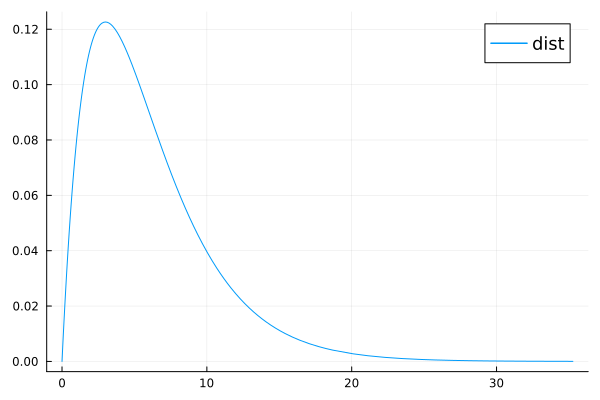

In [7]:
dist = Gamma(2, 3)
@show mu, sigma = mean(dist), std(dist)
plot(dist; label="dist")

In [8]:
X = rand(dist, 10) # X_1, X_2, ..., X_10 を生成

10-element Vector{Float64}:
  0.40805136957750254
 11.35246443572607
  1.7750298759291916
  2.871320442475634
  5.377988900748953
  1.6866822858975898
  4.050010771853904
  4.8982949336627355
  1.492397480850824
  1.1322589811898953

In [9]:
Xbar = cumsum(X) ./ (1:10) # Xbar_1, Xbar_2, ..., Xbar_10 を作成

10-element Vector{Float64}:
 0.40805136957750254
 5.8802579026517865
 4.511848560410922
 4.101716530927099
 4.356971004891471
 3.911922885059157
 3.9316497260298355
 4.052480376983947
 3.7680267218580448
 3.5044499477912296

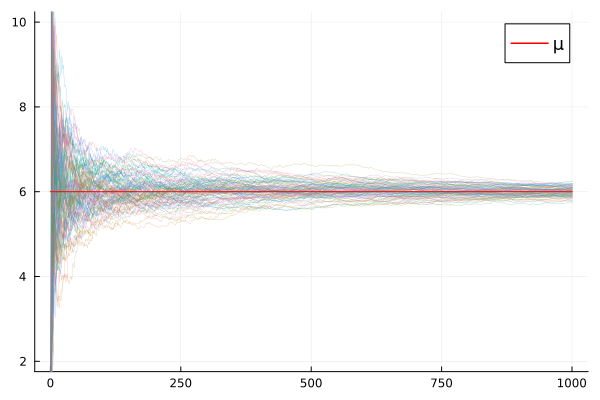

In [10]:
nmax = 1000 # maximum sample size
niters = 100 # number of iterations
Xbars = [cumsum(rand(dist, nmax)) ./ (1:nmax) for _ in 1:niters] # [Xbar_1, ..., Xbar_nmax] をniters個生成

plot()
for Xbar in Xbars
    plot!([0; Xbar]; label="", lw=0.3, alpha=0.5)
end
plot!(x -> mu, 0, nmax; label="µ", c=:red)
plot!(ylim=(mu-sigma, mu+sigma))

期待値が $0$ のギャンブルを $n$ 回繰り返すと, 1回ごとの勝ち負けの平均値は $\mu$ に近付く(大数の法則).

ランダムウォーク(トータルでの勝ち負けの金額の話)と大数の法則(トータルの勝ち負けの金額を繰り返した回数の $n$ で割って得られる1回ごとの平均値の話)を混同するとひどい目にあうだろう!

## 中心極限定理の素朴な確認の仕方

期待値が $\mu$ で標準偏差が $\sigma$ の確率分布の独立同分布確率変数列$X_1,X_2,X_3,\ldots$について, 標本平均 $\bar{X}_n = (X_1+\cdots+X_n)/n$ が従う分布は $n$ が大きなとき, 期待値 $\mu$ と標準偏差 $\sigma/\sqrt{n}$ を持つ正規分布で近似される. すなわち,

$$
Y_n = \sqrt{n}\;(\bar{X} - \mu)
= \frac{(X_1-\mu)+\cdots+(X_n-\mu)}{\sqrt{n}}
$$

が従う分布は, $n$が大きいとき, 期待値 $0$ と標準偏差 $\sigma$ を持つ正規分布で近似され, 

$$
Z_n = \frac{\sqrt{n}\;(\bar{X} - \mu)}{\sigma} 
= \frac{(X_1-\mu)+\cdots+(X_n-\mu)}{\sqrt{n}\;\sigma}
$$

が従う分布は, $n$が大きいとき, 標準正規分布で近似される.

(mu, sigma) = (mean(dist), std(dist)) = (6.0, 4.242640687119285)


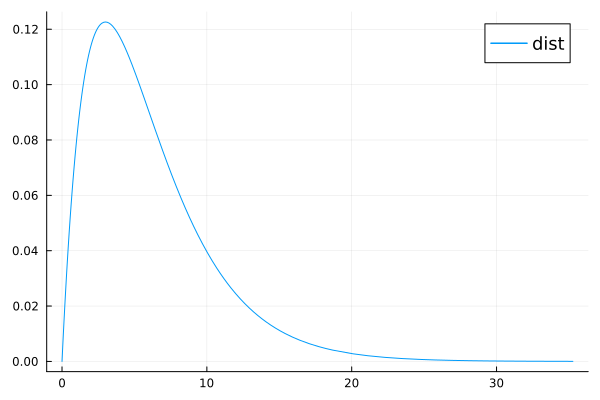

In [11]:
dist = Gamma(2, 3)
@show mu, sigma = mean(dist), std(dist)
plot(dist; label="dist")

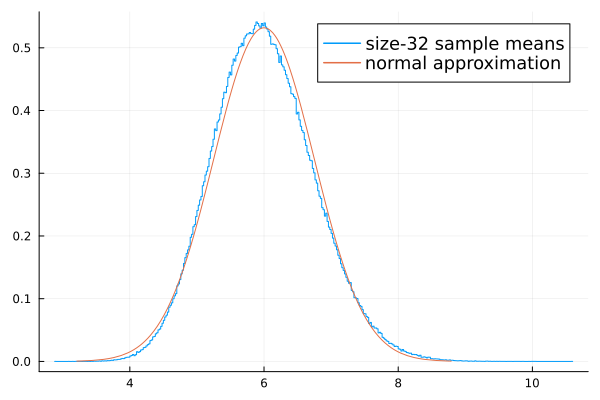

In [12]:
n = 2^5 # sample size
niters = 10^6 # number of iterations
Xbars = [mean(rand(dist, n)) for _ in 1:niters] # niters個の標本平均を計算

stephist(Xbars; norm=true, label="size-$n sample means")
plot!(Normal(mu, sigma/sqrt(n)); label="normal approximation")

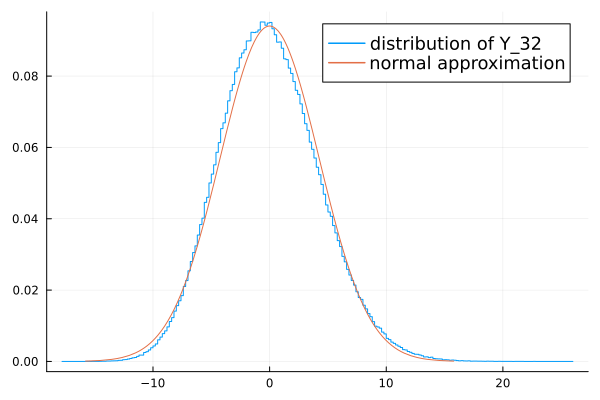

In [13]:
n = 2^5 # sample size
Yns = [sqrt(n) * (Xbar - mu) for Xbar in Xbars] # Z_nを繰り返し計算

stephist(Yns; norm=true, label="distribution of Y_$n")
plot!(Normal(0, sigma); label="normal approximation")

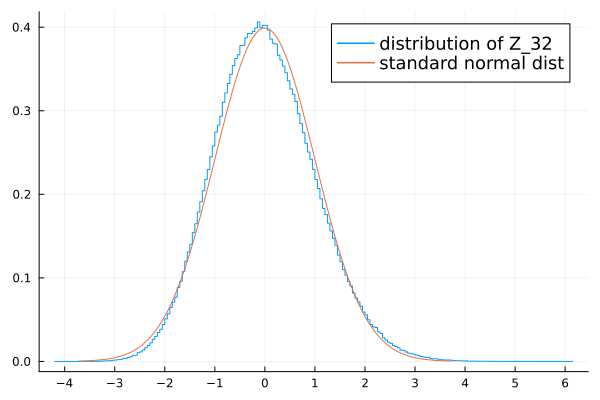

In [14]:
n = 2^5 # sample size
Zns = [sqrt(n) * (Xbar - mu) / sigma for Xbar in Xbars] # Z_nを繰り返し計算

stephist(Zns; norm=true, label="distribution of Z_$n")
plot!(Normal(); label="standard normal dist")
plot!(xtick=-10:10)

## 以下を自由に使って下さい.